- title: Reply code challenge 2019
- author: Alessandro Ogier
- date: 2019-03-16
- category: python
- tags: datascience,python,jupyter,cool

# Reply code challenge 2019

A data science layman approach

A sample exercise, taken from [contest's pdf](https://challenges.reply.com/tamtamy/file/download-99235.action) (*requires registration*).

Basically: given a map representation and a list of customers coordinates, find the N most convenient places that satisfy those constraint:

- cannot be built on mountains/customer cell
- connect to at least one customer via a path made by NSEW (ie. no diagonal) moves

Paths costs are the sum of cells costs (defined below). Each reached customers grant a reward `reward - moves_cost`.

In [1]:
rawmap = '''
####################
##_____T____##___###
####___X_#_______###
######_T_##______###
#___TXTT~~##__++__##
#___T_#~~~~##+++++_#
____T_#~~~~~#++++___
#______~~~~##+++___#
#_______~~#________#
___HHHH*HH*HHHHH*___
###__________#######
'''

customers = {(15, 1): {'reward': 1700},
             (14, 6): {'reward': 1200},
             (3, 8): {'reward': 1100},
             (17, 9): {'reward': 1050}
             }


In [2]:
tiles = {'#': {'type': 'mountains',
               'cost': 0},
         '~': {'type': 'water',
               'cost': 800},
         '*': {'type': 'traffic jam',
               'cost': 200},
         '+': {'type': 'dirt',
               'cost': 150},
         'X': {'type': 'railway level crossing',
               'cost': 120},
         '_': {'type': 'standard terrain',
               'cost': 100},
         'H': {'type': 'highway',
               'cost': 70},
         'T': {'type': 'railway',
               'cost': 50}
         }

Transpose the given map so we can use an (x,y) coordinate system

In [3]:
map = list(zip(*rawmap.split()))

Populate a graph with a node for every walkable tile (ie. non mountains)

In [4]:
import networkx as nx

G = nx.Graph()
for x in range(len(map)):
    for y in range(len(map[0])):
        if map[x][y] != '#':
            G.add_node((x, y), tile=map[x][y])

Enrich the graph nodes with customers' info


In [5]:
G.add_nodes_from(customers.items())

Connect every walkable node with his walkable neighbours (NSEW) via an edge

In [6]:
edges = []
for node in G.nodes:

    # possible NSEW neighbours' coordinates
    for x, y in [(node[0] - 1, node[1]),
                 (node[0] + 1, node[1]),
                 (node[0], node[1] + 1),
                 (node[0], node[1] - 1)]:

        try:
            # eclude mountains, negative coordinates
            if map[x][y] != '#' and not -1 in (x, y):
                edges.append((node, (x, y)))
        except IndexError:
            pass

G.add_edges_from(edges)

# Let's see what have we done so far

In [18]:
import plotly.offline as py
from plotly import graph_objs as go

py.init_notebook_mode(connected=True)

pos = nx.kamada_kawai_layout(G)

edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])


node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        # 'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        # 'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        # 'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=[],
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(
            width=2,
            color=[],
            colorscale='Reds'
        )))

import scipy
norm=scipy.linalg.norm([x['cost'] for x in tiles.values()])
for node, data in G.nodes(data=True):
    x, y = pos[node]
    node_type = tiles[data['tile']]['type']
    node_cost = tiles[data['tile']]['cost']
    if node in customers:
        node_size=20
        ct = '<br>CUSTOMER'
    else:
        node_size=10
        ct = ''
    
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['text'] += (f'{node}<br>'
                           f'type: {node_type}<br>'
                           f'cost: {node_cost}' + ct, )
    node_trace['marker']['line']['color'] += (node_cost/norm, )
    node_trace['marker']['size'] += (node_size, )
    
for adjacencies in G.adjacency():
    node_trace['marker']['color'] += tuple([len(adjacencies[1])])
    
annotations = [dict(
    x=pos[node][0],
    y=pos[node][1],
    xref='x',
    yref='y',
    text='A'

) for node, data in G.nodes(data=True)]


fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                title='<br>Map cells adjacencies',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20, l=5, r=5, t=40),
                annotations=[dict(
                    text="The redder the outline, the more it costs to pass (hover for details).",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002)],
                xaxis=dict(showgrid=False, zeroline=False,
                           showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

In this (basicly) interactive graph you see cell's transit cost (circle outline) and its adjacencies (1 to 4, obviously). Bigger nodes are customers.

(*Actual graph cells are hidden for the sake of brevity if you want to see how this is made then check out pages' repo [here](https://github.com/aogier/aogier.github.io/blob/source/content/reply-cc-2019.ipynb)*)

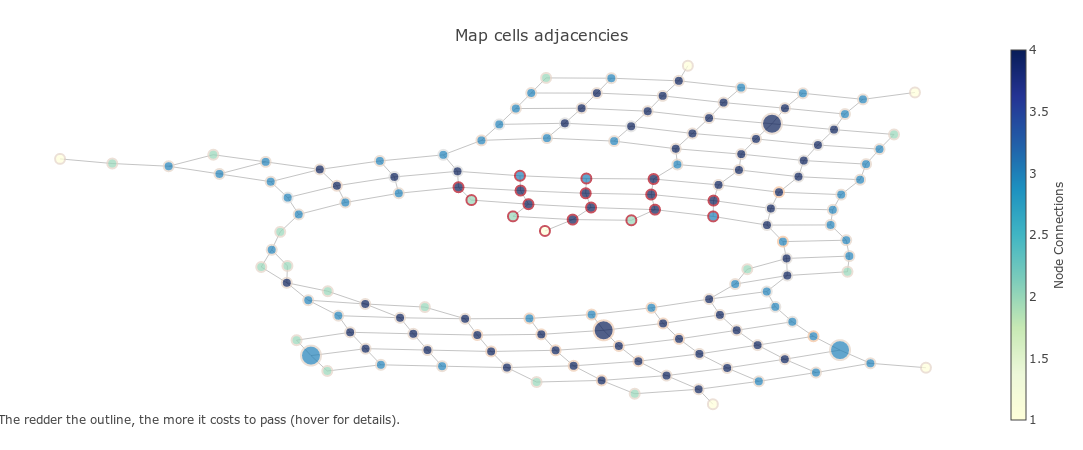

In [19]:
py.iplot(fig, filename='networkx')